In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.models import Sequential
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Data analysis

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   item      100000 non-null  object
 1   category  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB

First 5 rows of the dataset:
                            item  category
0  Impfuntersuchung Hund / Katze        19
1                   Cerenia 60mg        33
2         Impfbescheinigung (87)        19
3             Diagnosen: Impfung        13
4               Catalyst Chem 10        19

Statistical Summary:
            category
count  100000.000000
mean       24.463960
std         8.659614
min         0.000000
25%        19.000000
50%        19.000000
75%        33.000000
max        64.000000

Missing values per column:
item        0
category    0
dtype: int64

Value counts for the 'category' column:
category
19    50998
33    18864
30    12064
13     4358
12   

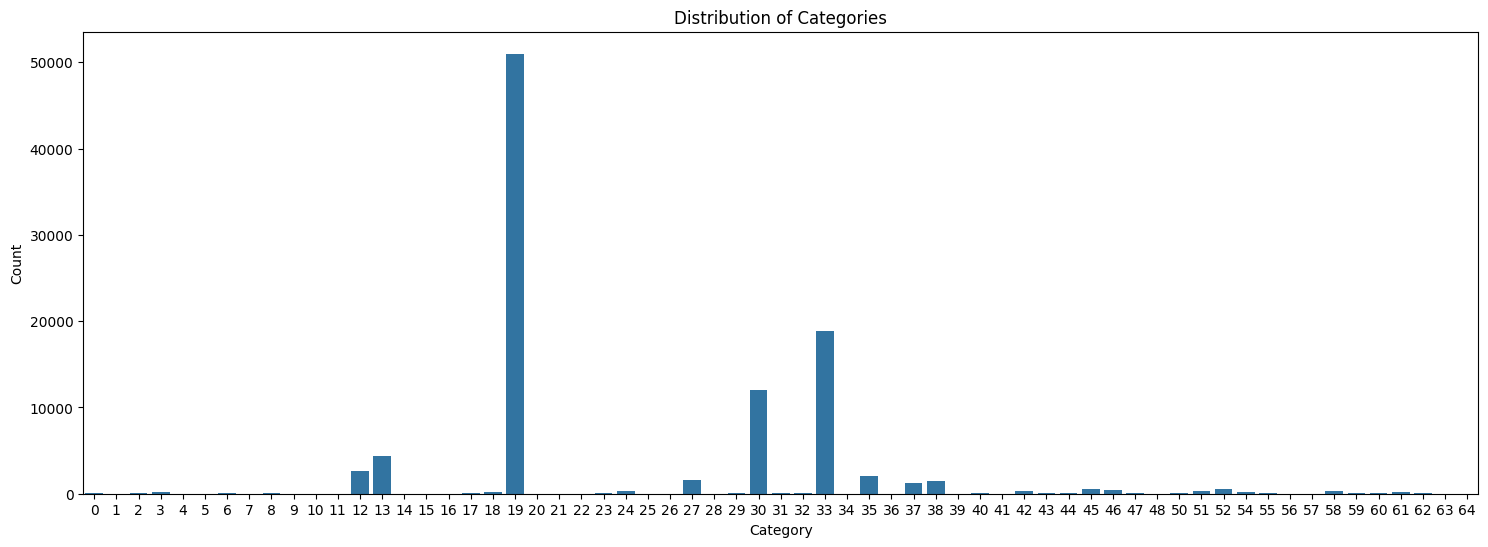


Average item length: 44.68701


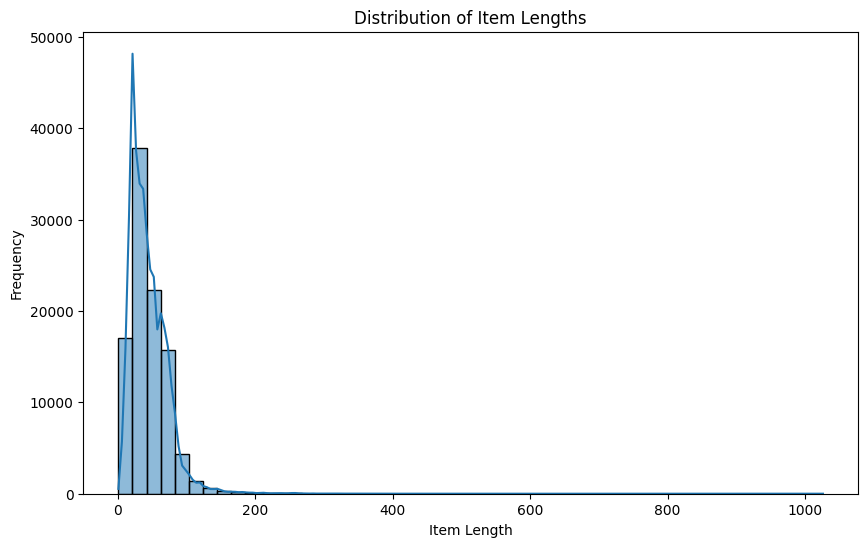

In [5]:
# Load and preprocess data
df = pd.read_csv('Datenset.csv', sep=';')
df.columns = ['item', 'category']
df.dropna(inplace=True)
print("Dataset Info:")
df.info()

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nValue counts for the 'category' column:")
print(df['category'].value_counts())

plt.figure(figsize=(18, 6))
sns.countplot(data=df, x='category')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

df['item_length'] = df['item'].apply(len)
print("\nAverage item length:", df['item_length'].mean())

# Plot the distribution of item lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='item_length', bins=50, kde=True)
plt.title('Distribution of Item Lengths')
plt.xlabel('Item Length')
plt.ylabel('Frequency')
plt.show()

df = df.drop(columns=['item_length'])

# Data preprocessing

In [6]:
# Split Data
X = df['item']
y = df['category']

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

os.makedirs('model', exist_ok=True)

# Save the label encoder
with open('model/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Text Vectorization
vectorize_layer = TextVectorization(
    max_tokens=15000,
    output_mode='int',
    output_sequence_length=60)
vectorize_layer.adapt(X_train)

with open('model/vectorize_layer.pkl', 'wb') as f:
    pickle.dump(vectorize_layer.get_vocabulary(), f)

# Modeling

In [7]:
# Build Model
num_classes = len(label_encoder.classes_)
model = Sequential([
    Input(shape=(None,), dtype='int64', name="input_layer"),
    Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        name="embedding_layer"),
    GlobalAveragePooling1D(name="pooling_layer"),
    Dense(64, activation='relu', name="dense_layer_1"),
    Dense(num_classes, activation='softmax', name="output_layer")
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting model training...")
# Vectorize the text data before passing it to the model
X_train_vectorized = vectorize_layer(tf.constant(X_train.to_numpy(), dtype=tf.string))
X_val_vectorized = vectorize_layer(tf.constant(X_val.to_numpy(), dtype=tf.string))

history = model.fit(
    X_train_vectorized, y_train_encoded,
    epochs=15,
    validation_data=(X_val_vectorized, y_val_encoded),
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
# Save Model
model.save('model/model.keras')
print("Model saved to 'invoice_model.keras'")

# Generate predictions
y_pred_probs = model.predict(X_val_vectorized)
y_pred = np.argmax(y_pred_probs, axis=1)

Starting model training...
Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.8193 - loss: 0.9514 - val_accuracy: 0.9374 - val_loss: 0.2278
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.9532 - loss: 0.1684 - val_accuracy: 0.9490 - val_loss: 0.1852
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.9687 - loss: 0.1046 - val_accuracy: 0.9506 - val_loss: 0.1784
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.9718 - loss: 0.0839 - val_accuracy: 0.9503 - val_loss: 0.1789
Epoch 5/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.9756 - loss: 0.0695 - val_accuracy: 0.9516 - val_loss: 0.1894
Epoch 6/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - accuracy: 0.9780 - loss: 0.0612 - val_accuracy: 0.9503 - val_loss: 0.1969
Model saved to 'invoice_model.keras'
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


# Evaluation


Classification Report (incl. macro & weighted averages):
              precision    recall  f1-score   support

           0      1.000     0.647     0.786        17
           1      0.000     0.000     0.000         3
           2      1.000     0.143     0.250         7
           3      0.964     0.871     0.915        31
           5      0.000     0.000     0.000         1
           6      1.000     0.810     0.895        21
           7      0.000     0.000     0.000         3
           8      0.857     0.923     0.889        13
           9      0.000     0.000     0.000         5
          10      0.000     0.000     0.000         2
          12      0.941     0.949     0.945       569
          13      0.997     0.995     0.996       866
          14      1.000     1.000     1.000         3
          15      0.000     0.000     0.000         2
          17      0.000     0.000     0.000         6
          18      0.897     0.812     0.852        32
          19      0.962

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


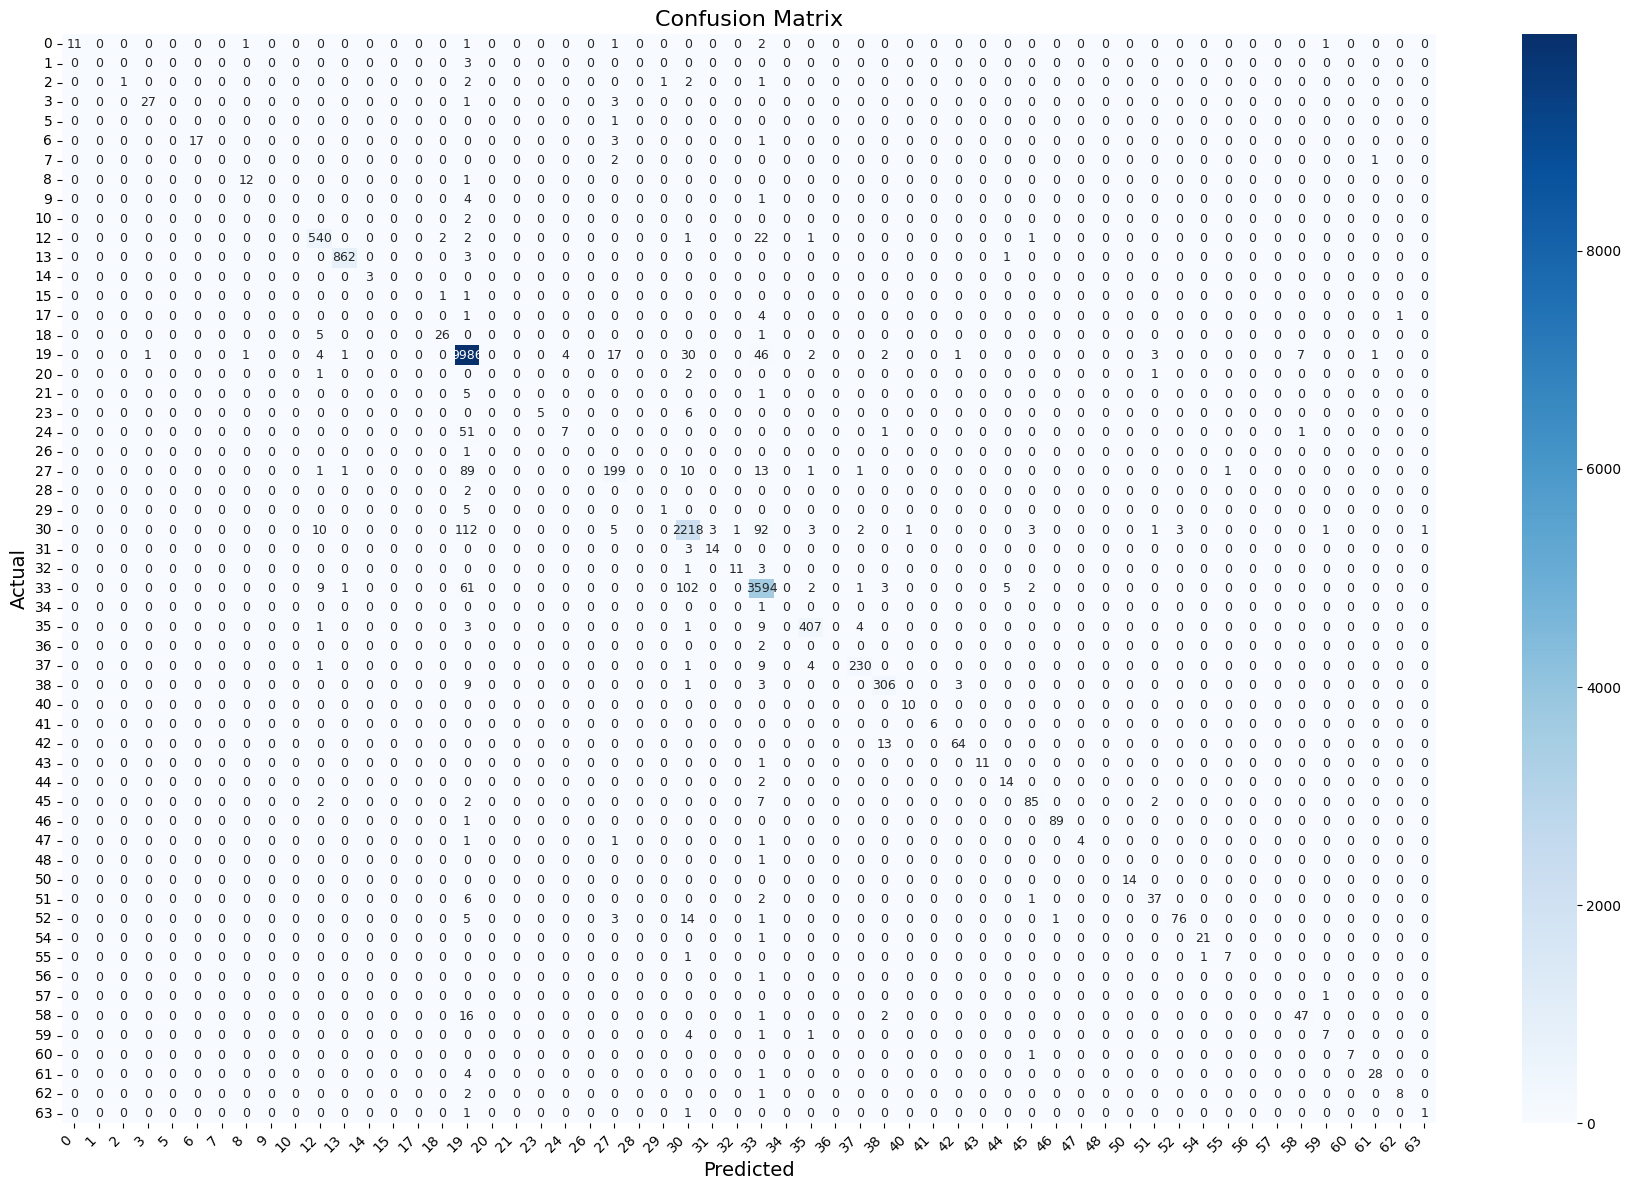


Average Precision (AUC-PR) per class:
  Class  0: AP = 0.792
  Class  1: AP = 1.000
  Class  2: AP = 0.199
  Class  3: AP = 0.893
  Class  5: AP = 0.002
  Class  6: AP = 0.894
  Class  7: AP = 0.475
  Class  8: AP = 0.840
  Class  9: AP = 0.217
  Class 10: AP = 0.077
  Class 12: AP = 0.982
  Class 13: AP = 1.000
  Class 14: AP = 1.000
  Class 15: AP = 0.002
  Class 17: AP = 0.089
  Class 18: AP = 0.873
  Class 19: AP = 0.996
  Class 20: AP = 0.136
  Class 21: AP = 0.014
  Class 23: AP = 0.599
  Class 24: AP = 0.321
  Class 26: AP = 0.001
  Class 27: AP = 0.772
  Class 28: AP = 0.503
  Class 29: AP = 0.572
  Class 30: AP = 0.970
  Class 31: AP = 0.846
  Class 32: AP = 0.857
  Class 33: AP = 0.990
  Class 34: AP = 0.001
  Class 35: AP = 0.986
  Class 36: AP = 0.501
  Class 37: AP = 0.972
  Class 38: AP = 0.959
  Class 40: AP = 1.000
  Class 41: AP = 1.000
  Class 42: AP = 0.917
  Class 43: AP = 0.923
  Class 44: AP = 0.693
  Class 45: AP = 0.940
  Class 46: AP = 1.000
  Class 47: AP = 0

In [13]:
print("\nClassification Report (incl. macro & weighted averages):")
unique_labels_val = np.unique(y_val_encoded)
target_names_subset = [str(c) for c in label_encoder.classes_ if label_encoder.transform([c])[0] in unique_labels_val]

print(classification_report(
    y_val_encoded,
    y_pred,
    labels=unique_labels_val,
    target_names=target_names_subset,
    digits=3
))

cm = confusion_matrix(y_val_encoded, y_pred, labels=unique_labels_val)

plt.figure(figsize=(18, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names_subset,
    yticklabels=target_names_subset,
    annot_kws={"size": 9}
)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


y_val_bin = label_binarize(y_val_encoded, classes=np.arange(len(label_encoder.classes_)))
ap_scores = {}
for i in unique_labels_val:
    ap = average_precision_score(y_val_bin[:, i], y_pred_probs[:, i])
    ap_scores[str(label_encoder.classes_[i])] = ap

print("\nAverage Precision (AUC-PR) per class:")
for cls, ap in ap_scores.items():
    print(f"  Class {cls:>2}: AP = {ap:.3f}")
print(f"\nMacro-average AP: {np.mean(list(ap_scores.values())):.3f}")
